In [1]:
###Hide
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from sklearn.decomposition import PCA
from sklearn import feature_selection as fs
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Source 2: National Child Development Study (NCDS - 1958 British Birth Cohort Study)

### Summary of data

#### NCDS Sweeps 0 to 3

The National Child Development Study (NCDS) originated in the Perinatal Mortality Survey, which examined social and obstetric factors associated with still birth and infant mortality among over 17,000 babies born in Britain in one week in March 1958.  The study has broadened in scope to chart many aspects of the health, educational, and social development of cohort members as they passed through childhood and adolescence. We used results from the first three sweeps (1965 at age 7, 1969 at age 11, 1974 at age 16) in addition to the birth data.

Surviving members of this birth cohort have been surveyed on five more occasions in order to monitor their changing health, education, social and economic circumstances.  We have excluded these datasets at this time in order to establish our baselines models.

In [2]:
#Load and inspect the ncds data
ncds_data = pd.read_csv('datasets/ncds0123.txt', delimiter='\t', low_memory=False)
# Print shapes
print "Shape of NCDS data:", ncds_data.shape
ncds_data.head()

Shape of NCDS data: (18558, 1765)


,ncdsid,n622,n0region,n1region,n2region,n3region,n553,n545,n520,n490,...,n1849,dvht07,dvht11,dvht16,dvrwt07,dvrwt11,dvrwt16,dvwt07,dvwt11,dvwt16
0,N10001N,2,9,9,9,9,23,4,2,12,...,-1,1.21899986267032,1.47299957275415,1.59999942779607,110.347991943347,98.1929931640604,105.055999755876,25.8549957275385,37.6489868164152,56.0199890136717
1,N10002P,1,9,8,8,8,34,4,5,1,...,-1,1.34599971771224,-1,-1,90.865997314449,-1,-1,26.3089904785155,-1,-1
2,N10003Q,1,4,4,4,4,34,4,10,1,...,-1,1.32099914550831,1.49899959564243,1.87999916076665,87.9599914550983,96.4049987792867,89.382995605487,24.4939880371087,38.1019897460905,66.6799926757659
3,N10004R,2,1,1,1,1,26,4,11,1,...,-1,1.29499912262003,1.51099967956562,1.62999916076665,105.16198730471,111.588989257796,132.054992675766,28.122985839843,45.8139953613169,72.7999877929584
4,N10005S,2,10,10,10,10,25,4,1,3,...,-1,1.34599971771224,-1,-1,129.382995605487,-1,-1,37.6489868164152,-1,-1


In [3]:
#Load and inspect the pms additions data
ncds_pms_data = pd.read_csv('datasets/ncds_pms_additionals.txt', delimiter='\t', low_memory=False)
# Print shapes
print "Shape of data:", ncds_pms_data.shape
ncds_pms_data.head()

Shape of data: (16990, 54)


,NCDSID,N622,BSTATUS,POD,BOOKING,PLANC,DIASTOL,MAXDBP,ALBECL,XRAY,...,DTB8,DTB9,DTB10,ILLNESS,MOD,TOD,AAD,SBNND,PLCWGT,TABLE62
0,N10001N,2,0,8,8,2,1,1,0,0,...,0,0,0,0,0,-1,-1,-1,-2,-1
1,N10002P,1,0,2,0,4,4,3,0,0,...,0,0,0,0,0,-1,-1,-1,-2,-1
2,N10003Q,1,0,8,8,2,1,3,0,0,...,0,0,1,3,0,-1,-1,-1,-2,-1
3,N10004R,2,0,8,8,2,1,-8,-8,1,...,1,0,0,-1,0,-1,-1,-1,-2,-1
4,N10005S,2,0,8,8,2,1,3,0,1,...,0,0,0,0,0,-1,-1,-1,-2,-1


In [4]:
#Load and inspect the response data
ncds_response_data = pd.read_csv('datasets/ncds_response.txt', delimiter='\t', low_memory=False)
# Print shapes
print "Shape of data:", ncds_response_data.shape
ncds_response_data.head()

Shape of data: (18558, 18)


,NCDSID,N622,BSTATUS,COBIRTH,MULTIPNO,MULTCODE,ETHNICID,OUTCME00,OUTCME01,OUTCME02,OUTCME03,OUTCME04,OUTCME05,OUTCME06,OUTCMEBM,OUTCME07,OUTCME08,OUTCME09
0,N10001N,2,0,1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1
1,N10002P,1,0,1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1
2,N10003Q,1,0,1,-1,-1,1,1,1,1,1,7,7,7,6,7,7,7
3,N10004R,2,0,1,-1,-1,1,1,1,1,1,1,1,1,1,2,2,3
4,N10005S,2,0,2,-1,-1,5,1,1,1,1,2,2,2,6,6,6,6


#### Understand the data:

1. Explore the data
2. Understand the predictors, what they mean in real life
3. Understand the values of each predictors
4. Join appropriate datasets

In [5]:
# Columns the help us identify if the patient has epilepsy
epil_columns = ["n390","n391","n392","n415", "n1842", "n1307", "n1308", "n1309", "n1314", "n1317", "n1477", "n1478", "n1479", "n2416", "n2663", "n2664", "n2665"
                , "n2666", "n2667", "n1893", "n1894", "n1895", "n1904", "n1910", 'n1817', 'n1818',  'n1394', 'n1502', 'n2615', 'n2616']

def evaluate_data(df):
    # Check for range of unique values for the train data
    for i in range(df.shape[1]):
        vals = np.unique(df.iloc[:, i])
        if len(vals) < 15:
            print '(Categorical) {} unique values - {}: {}'.format(len(vals), df.columns[i], vals)
        else:
            print '(Continuous) range of values - ', df.columns[i], ': {} to {}'.format(df.iloc[:, i].min(), df.iloc[:, i].max())

def evaluate_epil_columns(df):
    for column in epil_columns:
        vals = np.unique(df[column])
        if len(vals) < 15:
            print '(Categorical) {} unique values - {}: {}'.format(len(vals), column, vals)
        else:
            print '(Continuous) range of values - ', column, ': {} to {}'.format(df[column].min(), df[column].max())


def columns_with_null(df):
    for column in df.columns:
        df_missing = df[df[column].isnull()]
        count = 0
        if df_missing.shape[0] > 0:
            print "Predictor " , column, " contain null values / Count = " ,df_missing.shape[0]
            count = count +1
    print "Total number of columns with null:",count

In [6]:
# Join datasets
ncds_merged_data = pd.merge(left=ncds_data,right=ncds_pms_data,how='left',left_on='ncdsid',right_on='NCDSID')
ncds_merged_data = pd.merge(left=ncds_merged_data,right=ncds_response_data,how='left',left_on='ncdsid',right_on='NCDSID')
print "Shape of data:", ncds_merged_data.shape

Shape of data: (18558, 1837)


In [7]:
print "###Scroll" # This line is the scroll the output in the html view of this code file
# Evalute the ncds data
evaluate_data(ncds_merged_data)

###Scroll
(Continuous) range of values -  ncdsid : N10001N to N28558K
(Categorical) 4 unique values - n622: [' ' '-1' '1' '2']
(Categorical) 13 unique values - n0region: [' ' '-2' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']
(Categorical) 13 unique values - n1region: [' ' '-1' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']
(Categorical) 13 unique values - n2region: [' ' '-1' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']
(Categorical) 13 unique values - n3region: [' ' '-1' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']
(Continuous) range of values -  n553 :   to 8
(Categorical) 7 unique values - n545: [' ' '-1' '1' '2' '3' '4' '5']
(Continuous) range of values -  n520 :   to 9
(Continuous) range of values -  n490 :   to 9
(Categorical) 12 unique values - n492: [' ' '-1' '1' '10' '11' '12' '2' '3' '4' '5' '6' '9']
(Continuous) range of values -  n494 :   to 78
(Categorical) 9 unique values - n537: [' ' '-1' '1' '2' '3' '4' '5' '6' '8']
(Continuous) range of values -  n524 :   to 9
(Ca

//anaconda/envs/py27/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


(Categorical) 4 unique values - LDRUG03: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG04: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG05: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG06: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG07: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG08: [nan ' ' '0' '1']
(Categorical) 4 unique values - LDRUG09: [nan ' ' '0' '1']
(Categorical) 9 unique values - ATHETIC: [nan ' ' '-2' '0' '1' '2' '3' '4' '9']
(Categorical) 13 unique values - RESUS: [nan ' ' '-8' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
(Categorical) 4 unique values - DTB1: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB2: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB3: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB4: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB5: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB6: [nan ' ' '0' '1']
(Categorical) 4 unique values - DTB7: [nan ' ' '0' '1']
(Categorical) 4 uniq

#### Handle missing data:

Are there any missing values, if there are:
1. Can we impute them based on some algorithm
2. Remove or ignore them
3. Assume values based on common sense or prior knowledge

In [8]:
# Remove spaces from data
def convert_spaces_to_null(data):
    data = data.replace([' '],[None]) 
    return data

def fill_with_median(x_fill):
    x_fill = x_fill.groupby(x_fill.columns, axis = 1).transform(lambda x: x.fillna(x.median()))
    return x_fill

def fill_with_mean(x_fill):
    x_fill = x_fill.groupby(x_fill.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))
    return x_fill

def fill_pms_columns(x_fill):
    for index, row in x_fill.iterrows():
#         # 0-3D Sex of child 
#         if pd.isnull(row["N622"]):
#             x_fill.set_value(index, 'N622', -1.0)
        # Reconciled Birth Status  
#         if pd.isnull(row["BSTATUS"]):
#             x_fill.set_value(index, 'BSTATUS', 0)
        # Q6:Place of Delivery  
        if pd.isnull(row["POD"]):
            x_fill.set_value(index, 'POD', 5.0)
        # Q26b: Booking In place  
        if pd.isnull(row["BOOKING"]):
            x_fill.set_value(index, 'BOOKING', 3.0)
        # Q21b: Place of Antenatal care  
        if pd.isnull(row["PLANC"]):
            x_fill.set_value(index, 'PLANC', -8.0)
        # Q29a: Diastolic Blood Pressure  
        if pd.isnull(row["DIASTOL"]):
            x_fill.set_value(index, 'DIASTOL', -2.0)
        # Q29b: Maximum Diatolic Blood Pressure 
        if pd.isnull(row["MAXDBP"]):
            x_fill.set_value(index, 'MAXDBP', -2.0)
        # Q31: Albuminuria and Eclampsia
        if pd.isnull(row["ALBECL"]):
            x_fill.set_value(index, 'ALBECL', -8.0)
        # Q36: X-Ray given
        if pd.isnull(row["XRAY"]):
            x_fill.set_value(index, 'XRAY', -8.0)
        # Q37: Obstetric, pregnancy abnormality - No information
        if pd.isnull(row["ABNORM0X"]):
            x_fill.set_value(index, 'ABNORM0X', -2.0)
        # Q37: No Obstetric, pregnancy abnormality
        if pd.isnull(row["ABNORM00"]):
            x_fill.set_value(index, 'ABNORM00', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Diabetes
        if pd.isnull(row["ABNORM01"]):
            x_fill.set_value(index, 'ABNORM01', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Heart 
        if pd.isnull(row["ABNORM02"]):
            x_fill.set_value(index, 'ABNORM02', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Active TB 
        if pd.isnull(row["ABNORM03"]):
            x_fill.set_value(index, 'ABNORM03', -2.0)
        # Q37: Obstetric, pregnancy abnormality - influenza 
        if pd.isnull(row["ABNORM04"]):
            x_fill.set_value(index, 'ABNORM04', -2.0)
        # Q37: Obstetric, pregnancy abnormality - German Measles 
        if pd.isnull(row["ABNORM05"]):
            x_fill.set_value(index, 'ABNORM05', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Disproportion 
        if pd.isnull(row["ABNORM06"]):
            x_fill.set_value(index, 'ABNORM06', -2.0)
        # Q37: Obstetric, pregnancy abnormality - External version 
        if pd.isnull(row["ABNORM07"]):
            x_fill.set_value(index, 'ABNORM07', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Epilepsy 
        if pd.isnull(row["ABNORM08"]):
            x_fill.set_value(index, 'ABNORM08', -2.0)
        # Q37: Obstetric, pregnancy abnormality - Other 
        if pd.isnull(row["ABNORM09"]):
            x_fill.set_value(index, 'ABNORM09', -2.0)
        # Q37: Bleeding in Pregnancy and before delivery 
        if pd.isnull(row["BLEED"]):
            x_fill.set_value(index, 'BLEED', -1.0)
        # Q38a: Admission to hospital  
        if pd.isnull(row["AD2HOSP"]):
            x_fill.set_value(index, 'AD2HOSP', -1.0)
        # Q39: Type of Labour or Delivery Admission (Hospital)  
        if pd.isnull(row["ADTYPE"]):
            x_fill.set_value(index, 'ADTYPE', -1.0)
        # Q44: Presenting Part  
        if pd.isnull(row["PRESENT"]):
            x_fill.set_value(index, 'PRESENT', -1.0)
        # Q49a: No drugs of this type  
        if pd.isnull(row["LDRUG00"]):
            x_fill.set_value(index, 'LDRUG00', -2.0)
        # Q49a: Chloral, Welldorm  
        if pd.isnull(row["LDRUG01"]):
            x_fill.set_value(index, 'LDRUG01', -2.0)
        # Q49a: Barbiturate   
        if pd.isnull(row["LDRUG02"]):
            x_fill.set_value(index, 'LDRUG02', -2.0)
        # Q49a: Heroin   
        if pd.isnull(row["LDRUG03"]):
            x_fill.set_value(index, 'LDRUG03', -2.0)
        # Q49a: Largactil (chlorpomazine)   
        if pd.isnull(row["LDRUG04"]):
            x_fill.set_value(index, 'LDRUG04', -2.0)
        # Q49a: Sparine (promazine)    
        if pd.isnull(row["LDRUG05"]):
            x_fill.set_value(index, 'LDRUG05', -2.0)
        # Q49a: Phenergan (promethazine)    
        if pd.isnull(row["LDRUG06"]):
            x_fill.set_value(index, 'LDRUG06', -2.0)
        # Q49a: Doriden    
        if pd.isnull(row["LDRUG07"]):
            x_fill.set_value(index, 'LDRUG07', -2.0)
        # Q49a: Oblivon    
        if pd.isnull(row["LDRUG08"]):
            x_fill.set_value(index, 'LDRUG08', -2.0)
        # Q49a: Other    
        if pd.isnull(row["LDRUG09"]):
            x_fill.set_value(index, 'LDRUG09', -2.0)
        # Q50: Anaesthetic    
        if pd.isnull(row["ATHETIC"]):
            x_fill.set_value(index, 'ATHETIC', -2.0)
        # Q55: Resuscitation    
        if pd.isnull(row["RESUS"]):
            x_fill.set_value(index, 'RESUS', -2.0)
        # Q56: Drugs to baby (None)      
        if pd.isnull(row["DTB1"]):
            x_fill.set_value(index, 'DTB1', -2.0)
        # Q56: Drugs to baby (Coranine)       
        if pd.isnull(row["DTB2"]):
            x_fill.set_value(index, 'DTB2', -2.0)
        # Q56: Drugs to baby (Lobeline)       
        if pd.isnull(row["DTB3"]):
            x_fill.set_value(index, 'DTB3', -2.0)
        # Q56: Drugs to baby (Sedatives)       
        if pd.isnull(row["DTB4"]):
            x_fill.set_value(index, 'DTB4', -2.0)
        # Q56: Drugs to baby (Antagonists, nalorphine, levalorfan)       
        if pd.isnull(row["DTB5"]):
            x_fill.set_value(index, 'DTB5', -2.0)
        # Q56: Drugs to baby (Synkavit, Vikastab)      
        if pd.isnull(row["DTB6"]):
            x_fill.set_value(index, 'DTB6', -2.0)
        # Q56: Drugs to baby (Sulphonamides)      
        if pd.isnull(row["DTB7"]):
            x_fill.set_value(index, 'DTB7', -2.0)
        # Q56: Drugs to baby (Penicilin)      
        if pd.isnull(row["DTB8"]):
            x_fill.set_value(index, 'DTB8', -2.0)
        # Q56: Drugs to baby (Streptomycin)       
        if pd.isnull(row["DTB9"]):
            x_fill.set_value(index, 'DTB9', -2.0)
        # Q56: Drugs to baby (Other antibiotics)       
        if pd.isnull(row["DTB10"]):
            x_fill.set_value(index, 'DTB10', -2.0)
        # Q59: Baby's Illness       
        if pd.isnull(row["ILLNESS"]):
            x_fill.set_value(index, 'ILLNESS', -1.0)
        # Q61: Month of Death       
        if pd.isnull(row["MOD"]):
            x_fill.set_value(index, 'MOD', 0.0)
        # Q61: Time of death        
        if pd.isnull(row["TOD"]):
            x_fill.set_value(index, 'TOD', -1.0)
        # Q61: Age at Death        
        if pd.isnull(row["AAD"]):
            x_fill.set_value(index, 'AAD', -1.0)
        # Q61: Still Birth or Neo-natal Death (Dervied)         
        if pd.isnull(row["SBNND"]):
            x_fill.set_value(index, 'SBNND', -1.0)
        # Placental Weight         
        if pd.isnull(row["PLCWGT"]):
            x_fill.set_value(index, 'PLCWGT', -2.0)
        # Time of death for still births and neonatal deaths (Table 62)          
        if pd.isnull(row["TABLE62"]):
            x_fill.set_value(index, 'TABLE62', -1.0)
    return x_fill

In [9]:
# Make a copy
ncds_data_clean = ncds_merged_data.copy() 

# drop the ID columns
ncds_data_clean =  ncds_data_clean.drop(["ncdsid","NCDSID_x","NCDSID_y"],axis=1)
# Drop other duplicate columns
ncds_data_clean =  ncds_data_clean.drop(["N622_x","BSTATUS_x"],axis=1)


# Convert spaces in the data to nulls
ncds_data_clean = convert_spaces_to_null(ncds_data_clean)

# Convert all columns to float
for column in ncds_data_clean.columns:
    ncds_data_clean[column] = ncds_data_clean[column].astype(float)

# Impute missing data from joined columns using default values
ncds_data_clean = fill_pms_columns(ncds_data_clean)

# Impute missing data with median values
ncds_data_clean = fill_with_median(ncds_data_clean)

# Impute missing data with mean values - there are some columns we cannot impute with median
ncds_data_clean = fill_with_mean(ncds_data_clean)


In [10]:
# Get the columns which have null data
columns_with_null(ncds_data_clean)

Total number of columns with null: 0


#### Identify Epilepsy Records:

In our data a patient is assumed to be epileptic is one or more conditions are satisified in the dataset. We need to check all the conditions in the data and determine if the patient is epileptic.

In [11]:
# Identify if patient has epilepsy
ncds_data_clean["epileptic"] = 0
for index, row in ncds_data_clean.iterrows():
    # 1M Reason for Special Education MC1:3
    if row["n390"] == 10.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 1M Reason for Special Education MC2:3
    if row["n391"] == 10.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 1M Reason for Special Education MC2:3
    if row["n392"] == 10.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 1M Epileptic condition
    if row["n415"] >= 3.0 :
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 12D Epilepsy identification
    if row["n1842"] == 5.0 :
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Has child had epilepsy attacks-MC 1:3
    if (row["n1307"] >= 1.0 and row["n1307"] <= 5.0):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Has child had epilepsy attacks-MC 2:3
    if (row["n1308"] >= 1.0 and row["n1308"] <= 5.0):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Has child had epilepsy attacks-MC 3:3
    if (row["n1309"] >= 1.0 and row["n1309"] <= 5.0):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Age at most recent epilepsy attack
    if (row["n1314"] >= 0.0):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Age at 1st epilepsy attack
    if (row["n1317"] >= 0.0):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2M Reason for special education - MC1:3
    if row["n1477"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2M Reason for special education - MC2:3
    if row["n1478"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2M Reason for special education - MC3:3
    if row["n1479"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Type hcap for which will require help
    if row["n2416"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Nature of child-s disability-MC 1:5
    if row["n2663"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Nature of child-s disability-MC 2:5
    if row["n2664"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Nature of child-s disability-MC 3:5
    if row["n2665"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Nature of child-s disability-MC 4:5
    if row["n2666"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Nature of child-s disability-MC 5:5
    if row["n2667"] == 7.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Category of child's handicap MC1:3
    if row["n1893"] == 8.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Category of child's handicap MC2:3
    if row["n1894"] == 8.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Category of child's handicap MC3:3
    if row["n1895"] == 8.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Reason for hosp admiss last 12 mnths
    if row["n1904"] == 17.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Reason hosp outpatient last yr
    if row["n1910"] == 17.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3M Epilepsy
#     if row["n2032"] >= 1.0:
#         ncds_data_clean.set_value(index, 'epileptic', 1)
    
    # New columns 
    
    # 1D Defects found in NCDS1 sample-MC 1:4
    if row["n1817"] > 0.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 1D Defects found in NCDS1 sample-MC 2:4
    if row["n1818"] > 0.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 1D Defects found in NCDS1 sample-MC 3:4
    if row["n1819"] > 0.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2P Ever seen specialist-convulsions,fits
    if row["n1394"] == 5.0:
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 2M Has child ever had convulsions
    if any(row["n1502"] == s for s in [2.0,3.0,4.0]):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P When convulsions,fits 1st occured
    if any(row["n2615"] == s for s in [1.0,2.0,3.0,4.0,5.0,6.0]):
        ncds_data_clean.set_value(index, 'epileptic', 1)
    # 3P Convulsions-most recent occurrence
    if any(row["n2616"] == s for s in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]):
        ncds_data_clean.set_value(index, 'epileptic', 1)

In [12]:
print "Number of rows with epilepsy",ncds_data_clean[ncds_data_clean["epileptic"] == 1].shape[0]

Number of rows with epilepsy 1609


In [13]:
# Remove the epilepsy columns from the data
ncds_data_no_indicators=ncds_data_clean.copy()
ncds_data_no_indicators.drop(epil_columns,inplace=True,axis=1)
print "Shape of dataset: " , ncds_data_no_indicators.shape

Shape of dataset:  (18558, 1803)


## Feature Exploration

From the merged datasets we can see we have over 1800 features. Going through the 1800 would be a very time consuming task so let us apply some algorithims to find the best features that are most important.

In [14]:
# Split data into train and test
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

#Print some useful info for our test, train sets
print 'Train data: ', x_train.shape
print 'Test data: ', x_test.shape
print 'Train class 0: {}, train class 1: {}'.format(len(y_train[y_train == 0]), len(y_train[y_train == 1]))
print 'Test class 0: {}, test class 1: {}'.format(len(y_test[y_test == 0]), len(y_test[y_test == 1]))

Train data:  (11134, 1802)
Test data:  (7424, 1802)
Train class 0: 10159, train class 1: 975
Test class 0: 6790, test class 1: 634


#### Best features using SelectKBest

In [15]:
# Best features
num_of_features = 15
features = fs.SelectKBest(fs.f_regression, k=num_of_features) #k is number of features.
features.fit(x_train, y_train)

selected_features = features.get_support()
print "Selected Features:"
selected_features_columns =  ncds_data_no_indicators.columns[selected_features].values
print selected_features_columns

Selected Features:
['n1827' 'n604' 'n39' 'n1263' 'n1400' 'n1399' 'n1453' 'n1476' 'n825'
 'n2598' 'n1896' 'n1898' 'dvht07' 'OUTCME01' 'OUTCME02']


//anaconda/envs/py27/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1803 but corresponding boolean dimension is 1802
  result = getitem(key)


#### Best features using PCA

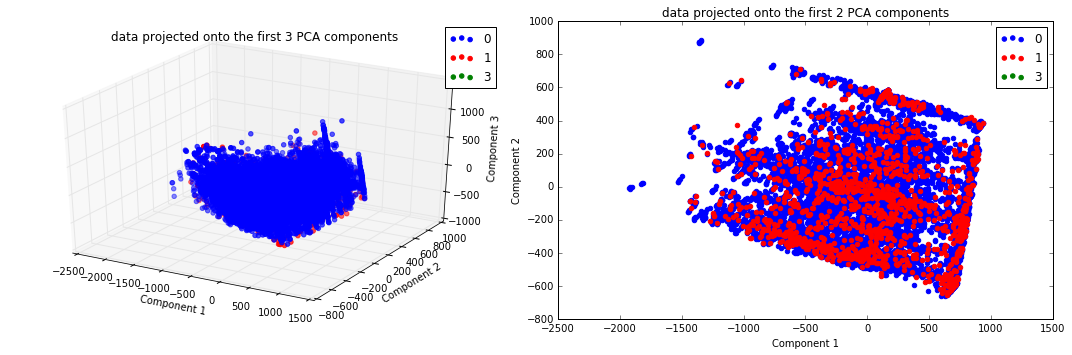

In [16]:
#Apply PCA to data and get the top 3 axes of maximum variation
pca = PCA(n_components=3)
pca.fit(x)

#Project to the data onto the three axes
x_reduced = pca.transform(x)

#Visualized our reduced data
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1,  projection='3d')
ax1.scatter(x_reduced[y==0, 0], x_reduced[y==0, 1], x_reduced[y==0, 2], c='b', color='b', label='0')
ax1.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], x_reduced[y==1, 2], c='r', color='r', label='1')
ax1.scatter(x_reduced[y==3, 0], x_reduced[y==3, 1], x_reduced[y==3, 2], c='g', color='g', label='3')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_zlabel('Component 3')
ax1.set_title('data projected onto the first 3 PCA components')
ax1.legend()

#Apply PCA to data and get the top 2 axes of maximum variation
pca = PCA(n_components=2)
pca.fit(x)

#Project to the data onto the three axes
x_reduced = pca.transform(x)

#Visualized our reduced data
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(x_reduced[y==0, 0], x_reduced[y==0, 1], c='b', color='b', label='0')
ax2.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], c='r', color='r', label='1')
ax2.scatter(x_reduced[y==3, 0], x_reduced[y==3, 1], c='g', color='g', label='3')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('data projected onto the first 2 PCA components')
ax2.legend()

plt.tight_layout()
plt.show()

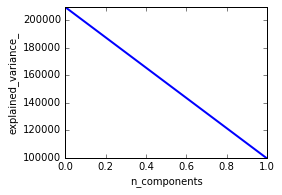

In [18]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')


In [19]:
#gets the vector for the 0-th component
comp_0 = pca.components_[0]
#gets the vector for the 1-st component
comp_1 = pca.components_[1]

print comp_0
print comp_1

[ -9.28577136e-06  -1.03507066e-03  -9.75449853e-04 ...,   2.30655764e-04
   1.92495791e-04   2.76155806e-04]
[  1.53896258e-05  -1.37105393e-03  -1.00718676e-03 ...,   9.00373418e-04
   7.96863355e-04   6.70178299e-04]


In [20]:
# Dump components relations with features:
# http://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
print pd.DataFrame(pca.components_,columns=ncds_data_no_indicators.columns[:-1],index = ['PC-1','PC-2'])

          n622  n0region  n1region  n2region  n3region      n553      n545  \
PC-1 -0.000009 -0.001035 -0.000975 -0.001112 -0.001377  0.000104 -0.000010   
PC-2  0.000015 -0.001371 -0.001007 -0.002308 -0.005518 -0.000055  0.000001   

          n520      n490      n492    ...     OUTCME01  OUTCME02  OUTCME03  \
PC-1  0.000024  0.000372 -0.000030    ...     0.000088  0.000117  0.000176   
PC-2 -0.000321  0.000427 -0.000056    ...    -0.000261  0.000433  0.001405   

      OUTCME04  OUTCME05  OUTCME06  OUTCMEBM  OUTCME07  OUTCME08  OUTCME09  
PC-1  0.000220  0.000184  0.000188  0.000204  0.000231  0.000192  0.000276  
PC-2  0.000828  0.000869  0.000882  0.000560  0.000900  0.000797  0.000670  

[2 rows x 1802 columns]


In [21]:
pca = PCA(n_components=10)
pca.fit(x)

print pca.explained_variance_ratio_

[ 0.45458608  0.21648089  0.08186103  0.03818444  0.02570534  0.01987003
  0.01565043  0.01403758  0.01269126  0.01114309]


In [22]:
print pd.DataFrame(pca.components_,columns=ncds_data_no_indicators.columns[:-1],index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10'])

           n622  n0region  n1region  n2region  n3region      n553      n545  \
PC-1  -0.000009 -0.001035 -0.000975 -0.001112 -0.001377  0.000104 -0.000010   
PC-2   0.000015 -0.001371 -0.001007 -0.002308 -0.005518 -0.000055  0.000001   
PC-3   0.000026  0.002325  0.002852  0.001644  0.001088 -0.000274  0.000011   
PC-4  -0.000018  0.001343  0.002476  0.003288  0.001591 -0.000311 -0.000013   
PC-5   0.000024  0.000657  0.000258 -0.002027 -0.001114  0.000379 -0.000057   
PC-6  -0.000107  0.000484  0.003607  0.004085  0.003223  0.000721  0.000010   
PC-7   0.000043 -0.002837  0.000798  0.000537  0.001765  0.002511 -0.000041   
PC-8  -0.000137  0.000407 -0.007198 -0.006854 -0.008865  0.000203  0.000016   
PC-9   0.000245  0.002621  0.004526  0.002314  0.001525  0.002197  0.000008   
PC-10 -0.000338  0.001820 -0.000279 -0.000007 -0.000141  0.000437 -0.000029   

           n520      n490      n492    ...     OUTCME01  OUTCME02  OUTCME03  \
PC-1   0.000024  0.000372 -0.000030    ...     0.00